# Dataset: Baseball Players
In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

Format: A data frame with 322 observations of major league players on the following 20 variables.

AtBat: Number of times at bat in 1986

Hits: Number of hits in 1986

HmRun: Number of home runs in 1986

Runs: Number of runs in 1986

RBI: Number of runs batted in in 1986

Walks: Number of walks in 1986

Years: Number of years in the major leagues

CAtBat: Number of times at bat during his career

CHits: Number of hits during his career

CHmRun: Number of home runs during his career

CRuns: Number of runs during his career

CRBI: Number of runs batted in during his career

CWalks: Number of walks during his career

League: A factor with levels A and N indicating player’s league at the end of 1986

Division: A factor with levels E and W indicating player’s division at the end of 1986

PutOuts: Number of put outs in 1986

Assists: Number of assists in 1986

Errors: Number of errors in 1986

Salary: 1987 annual salary on opening day in thousands of dollars

NewLeague: A factor with levels A and N indicating player’s league at the beginning of 1987

You can download the dataset from here: https://www.dropbox.com/s/boshaqfgdjiaxh4/Hitters.csv?dl=1

A couple notes about this lab:

1. Although it isn’t listed as a specific question, don’t forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?

2. There are a lot of variables in the dataset! You may want to use the remainder = "passthrough" trick in your column transformers, rather than typing out a ton of gene names.

3. Don’t forget that in penalized regression, we must standardize our numeric variables.

4. There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.



In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from plotnine import *

In [2]:
hitters = pd.read_csv('https://www.dropbox.com/s/boshaqfgdjiaxh4/Hitters.csv?dl=1')
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
hitters = hitters.dropna(subset=['Salary'])
len(hitters)

263

I removed 59 observations with missing "salary" values because they would interfere with model training and evaluation. Since "salary" is the target variable, observations without it can’t help assess model performance. Removing these ensures cross-validation can accurately evaluate the model across all data points. After removing the observations with missing "salary" values, there are now 263 observations in the data set.

# Part I: Different Model Specs

## A. Regression without regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression.

In [4]:
# Define X and y
X = hitters.drop("Salary", axis=1)
y = hitters["Salary"]

# Function to create and evaluate pipeline
def create_pipeline(model):
  """
  Creates and fits a pipeline that preprocesses data (standardizes numerical variables and dummifies categorical variables)
  and fits the specified regression model.
  This function returns the fitted pipeline.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
    pipeline : Pipeline
        The fitted pipeline, including preprocessing and the specified model.
  """
  
  ct = ColumnTransformer(
    [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
       make_column_selector(dtype_include=object)),
      ("standardize", StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "passthrough"
  )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]
  )
  
  # Fit the pipeline to the data
  pipeline.fit(X, y)

  return pipeline

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [5]:
def get_coefficients(model):
  """
  Creates and fits a pipeline that preprocesses data (standardizes numerical variables and dummifies categorical variables)
  and fits the specified regression model. This function returns the model's top predictors based on their coefficients.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
     coef_df : DataFrame
        A DataFrame containing the top predictors with the highest coefficients, sorted in descending order.
        Columns:
            - "Predictor": The feature name after preprocessing.
            - "Coefficient": The estimated coefficient for each predictor.
  """
  ct = ColumnTransformer(
    [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
       make_column_selector(dtype_include=object)),
      ("standardize", StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "passthrough"
  )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]).set_output(transform="pandas")

  pipeline.fit(X, y)
  coefficients = pipeline.named_steps['model'].coef_
  var_names = ct.fit_transform(X).columns

  coef_df = pd.DataFrame({
    "Predictor": var_names,
    "Coefficient": coefficients
  }).sort_values(by="Coefficient", key=abs, ascending=False)

  return coef_df

In [6]:
linear_model = get_coefficients(LinearRegression())
print(linear_model)

               Predictor  Coefficient
13    standardize__CRuns   480.747135
10   standardize__CAtBat  -391.038655
4      standardize__Hits   337.830479
3     standardize__AtBat  -291.094556
14     standardize__CRBI   260.689886
15   standardize__CWalks  -213.892259
8     standardize__Walks   135.073897
1    dummify__Division_W  -116.849246
11    standardize__CHits    86.687617
16  standardize__PutOuts    78.761296
0      dummify__League_N    62.599423
6      standardize__Runs   -60.572479
17  standardize__Assists    53.732490
5     standardize__HmRun    37.853837
7       standardize__RBI   -26.994984
2   dummify__NewLeague_N   -24.762325
18   standardize__Errors   -22.160862
9     standardize__Years   -16.693359
12   standardize__CHmRun   -14.181723


Based on the output, here are interpretations for the most important predictors:  
- **CRuns (Coefficient = 480.75)**: A one standard deviation increase in career runs is associated with an increase in salary by approximately $480,750, holding all other variables constant. This positive relationship suggests that players with more career runs tend to be valued more highly in salary terms.  
- **CAtBat (Coefficient = -391.04)**: A one standard deviation increase in career at-bats corresponds to a decrease in salary by about $391,040, holding all other variables constant. This negative association may indicate that high at-bat counts alone don’t correlate with higher salary.  
- **Hits (Coefficient = 337.83)**: A one standard deviation increase in hits is linked to a salary increase of about $337,830, holding other variables constant. This suggests that hitting performance plays a significant role in salary determination.  

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [7]:
def evaluate_pipeline_mse(model):
    """
    Evaluates the mean squared error (MSE) of a model using cross-validation.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
    mse : float
        The mean squared error (MSE) estimated using cross-validation.
    """

    ct = ColumnTransformer(
      [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
       make_column_selector(dtype_include=object)),
      ("standardize", StandardScaler(), 
      make_column_selector(dtype_include=np.number))
      ],
    remainder = "passthrough"
  )

    pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]
  )
  
    # Fit the pipeline to the data
    pipeline.fit(X, y)
    
    # Cross-validation to estimate the Mean Squared Error (MSE)
    mse = -cross_val_score(pipeline, X, y, scoring="neg_mean_squared_error", cv=5).mean()
    
    print("MSE:", mse)
    return mse

In [8]:
linear_mse = evaluate_pipeline_mse(LinearRegression())

MSE: 121136.3103181688


The Mean Squared Error (MSE) of about 121,136 means that, on average, the squared difference between predicted and actual salaries is quite large. This suggests the model’s predictions may be off by a considerable amount, indicating that the model may need improvement,

## B. Ridge regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ridge regression.

In [9]:
ridge_pipeline = create_pipeline(model=Ridge())

2. Use cross-validation to tune the $\lambda$ hyperparameter.

In [10]:
def tune_alpha(pipeline, alpha_values, l1_ratio_values=None):
    """
    Performs cross-validation to tune the alpha (λ) and  l1_ratio (α) hyperparameters for a given model pipeline.

    Parameters:
    -----------
    pipeline : Pipeline object
        The pipeline containing preprocessing and a regression model instance (e.g., Ridge, Lasso, ElasticNet).
    alpha_values : list
        A list of alpha values to test during cross-validation.
    l1_ratio_values : list, optional
        A list of l1_ratio values to test during cross-validation (only used for ElasticNet).

    Returns:
    --------
    results : DataFrame
        A DataFrame showing the alpha values and corresponding mean test scores (MSE).
    """
    
    # Define the parameter grid for alpha
    param_grid = {'model__alpha': alpha_values}
    
    # If l1_ratio_values is provided, add it to the grid (for ElasticNet)
    if l1_ratio_values is not None:
        param_grid['model__l1_ratio'] = l1_ratio_values
    
    # Set up GridSearchCV with the pipeline, parameter grid, and scoring
    gscv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Fit the GridSearchCV
    gscv_fitted = gscv.fit(X, y)
    
    # Create a DataFrame with the results
    results = pd.DataFrame({
        "alpha": gscv_fitted.cv_results_['param_model__alpha'].data,
        "mean_test_score": -gscv_fitted.cv_results_['mean_test_score']  # Convert back to positive MSE
    })
    
    # Include l1_ratio in results if used
    if l1_ratio_values is not None:
        results["l1_ratio"] = gscv_fitted.cv_results_['param_model__l1_ratio'].data

    return results

In [11]:
ridge_results = tune_alpha(ridge_pipeline, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(ridge_results)

     alpha  mean_test_score
0    0.001    121124.318914
1    0.010    121021.508944
2    0.100    120329.936014
3    1.000    119034.332720
4   10.000    119073.956166
5  100.000    121274.424070


The best value for $\lambda$ is 1.0 because it yields the lowest MSE of 119034.33

3. Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients.

In [12]:
ridge_model = get_coefficients(Ridge(alpha = 1.0))
print(ridge_model)

               Predictor  Coefficient
13    standardize__CRuns   320.802717
4      standardize__Hits   296.801967
3     standardize__AtBat  -271.088165
10   standardize__CAtBat  -225.511649
15   standardize__CWalks  -184.289408
14     standardize__CRBI   160.409497
11    standardize__CHits   126.210585
8     standardize__Walks   124.344012
1    dummify__Division_W  -119.076927
16  standardize__PutOuts    78.651037
0      dummify__League_N    58.555947
17  standardize__Assists    47.493631
12   standardize__CHmRun    39.055346
9     standardize__Years   -38.619131
6      standardize__Runs   -29.212352
2   dummify__NewLeague_N   -24.027205
18   standardize__Errors   -23.651303
5     standardize__HmRun    17.973971
7       standardize__RBI    -8.909304


Based on the output, here are interpretations for the most important predictors:  
- **CRuns (Coefficient = 320.80)**: A one standard deviation increase in career runs is associated with an increase in salary by approximately $320,800, holding all other variables constant. This positive relationship suggests that players with more career runs are generally valued higher in terms of salary.  
- **Hits (Coefficient = 296.80)**: A one standard deviation increase in hits is linked to a salary increase of about $296,800, holding other variables constant. This suggests that hitting performance plays a key role in salary determination.  
- **AtBat (Coefficient = -271.08)**: A one standard deviation increase in career at-bats corresponds to a decrease in salary by about $271,080, holding all other variables constant. This negative association suggests that more at-bats may be associated with lower salary valuation.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [13]:
ridge_mse = evaluate_pipeline_mse(Ridge(alpha = 1.0))

MSE: 119034.33271954537



The Ridge regression model with $\lambda = 1.0$ has an MSE of approximately 119,034, which is slightly lower than the MSE for the linear regression model. This suggests that Ridge's regularization helps improve prediction accuracy by reducing overfitting, making it a more reliable choice for predicting salaries.

## C. Lasso Regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs Lasso regression.

In [14]:
lasso_pipeline = create_pipeline(model=Lasso(max_iter=10000))
# Set max_iter=10000 to ensure the Lasso model has enough iterations to converge

2. Use cross-validation to tune the $\lambda$ hyperparameter.

In [15]:
lasso_results = tune_alpha(lasso_pipeline, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(lasso_results)

     alpha  mean_test_score
0    0.001    121132.276754
1    0.010    121096.159270
2    0.100    120758.508162
3    1.000    119758.108873
4   10.000    121828.141333
5  100.000    143755.162381


The best value for $\lambda$ is 1.0 because it yields the lowest MSE of 119758.11.

3. Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients

In [16]:
lasso_model = get_coefficients(Lasso(alpha = 1.0))
print(lasso_model)

               Predictor  Coefficient
13    standardize__CRuns   375.565519
4      standardize__Hits   304.359509
3     standardize__AtBat  -282.370957
14     standardize__CRBI   192.610892
15   standardize__CWalks  -189.644642
10   standardize__CAtBat  -162.639794
8     standardize__Walks   120.695275
1    dummify__Division_W  -114.412951
16  standardize__PutOuts    78.760366
17  standardize__Assists    41.996680
0      dummify__League_N    35.826072
9     standardize__Years   -34.948148
6      standardize__Runs   -24.966507
18   standardize__Errors   -18.479378
12   standardize__CHmRun    14.225993
5     standardize__HmRun    11.127022
2   dummify__NewLeague_N    -0.000000
7       standardize__RBI    -0.000000
11    standardize__CHits     0.000000


Based on the output, here are interpretations for the most important predictors:  
- **CRuns (Coefficient = 375.57)**: A one standard deviation increase in career runs is associated with an increase in salary by approximately $375,570, holding all other variables constant. This positive relationship suggests that players with more career runs are generally valued higher in terms of salary.  
- **Hits (Coefficient = 304.36)**: A one standard deviation increase in hits is linked to a salary increase of about $304,360, holding other variables constant. This suggests that hitting performance plays a key role in salary determination.  
- **AtBat (Coefficient = -282.38)**: A one standard deviation increase in career at-bats corresponds to a decrease in salary by about $282,380, holding all other variables constant. This negative association suggests that more at-bats may be associated with lower salary valuation.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [17]:
lasso_mse = evaluate_pipeline_mse(Lasso(alpha=1.0, max_iter=10000))

MSE: 119758.10887295294


The Lasso model with $\lambda = 1.0$ has an MSE of approximately 119,758, which is slightly lower than the MSE of the Linear Regression model (121,136) and very close to the Ridge Regression model's MSE (119,034). This result suggests that Lasso’s feature selection and Ridge’s shrinkage both contribute to slightly improved predictive accuracy over the Linear model. However, Ridge performed the best, indicating that while Lasso’s feature selection is helpful, the Ridge model’s approach to regularization is more effective for minimizing error in this dataset

## D. Elastic Net
1. Create a pipeline that includes all the columns as predictors for Salary, and performs elastic net.

In [18]:
elastic_pipeline = create_pipeline(model=ElasticNet(max_iter=100000))

2. Use cross-validation to tune the $\lambda$ and $\alpha$ hyperparameters.

In [19]:
elastic_results = tune_alpha(elastic_pipeline, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100], l1_ratio_values=[0.1, 0.3, 0.5, 0.7, 0.8, 0.9])
print(elastic_results.sort_values(by='mean_test_score', ascending=True).head(5))

    alpha  mean_test_score  l1_ratio
16   0.10    118750.189196       0.8
17   0.10    118794.049617       0.9
6    0.01    118802.210703       0.1
15   0.10    118841.088130       0.7
7    0.01    118880.541026       0.3


The best parameter values are $\lambda = 0.1$ and $\alpha = 0.8$ because they yield the lowest MSE of 118750.19.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

In [20]:
elastic_model = get_coefficients(ElasticNet(alpha=0.1, l1_ratio=0.8))
print(elastic_model)

               Predictor  Coefficient
4      standardize__Hits   200.830729
3     standardize__AtBat  -186.181515
13    standardize__CRuns   163.907498
15   standardize__CWalks  -125.175493
1    dummify__Division_W  -116.818145
11    standardize__CHits   110.173426
14     standardize__CRBI   104.504476
8     standardize__Walks    97.341332
16  standardize__PutOuts    76.907372
12   standardize__CHmRun    59.364022
10   standardize__CAtBat   -57.402148
9     standardize__Years   -52.040838
0      dummify__League_N    45.390029
17  standardize__Assists    35.091056
18   standardize__Errors   -24.758404
2   dummify__NewLeague_N   -12.909402
7       standardize__RBI    10.165051
6      standardize__Runs     9.950553
5     standardize__HmRun    -3.812007


Based on the output, here are interpretations for the most important predictors:  
- **Hits (Coefficient = 200.83)**: A one standard deviation increase in hits is linked to a salary increase of about $200,830, holding other variables constant. This suggests that hitting performance plays a key role in salary determination.  
- **AtBat (Coefficient = -186.18)**: A one standard deviation increase in career at-bats corresponds to a decrease in salary by about $186,180, holding all other variables constant. This negative association suggests that more at-bats may be associated with lower salary valuation.  
- **CRuns (Coefficient = 163.10)**: A one standard deviation increase in career runs is associated with an increase in salary by approximately $163,100, holding all other variables constant. This positive relationship suggests that players with more career runs are generally valued higher in terms of salary.  

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [21]:
elastic_mse = evaluate_pipeline_mse(ElasticNet(alpha=0.1, l1_ratio=0.8, max_iter=10000))

MSE: 118750.18919600834


The MSE for the Elastic Net model (118750.19) is slightly lower than the MSEs of Ridge (119034.33) and Lasso (119758.11), and notably lower than the Linear Regression MSE (121136.31). This indicates that Elastic Net gives the most accurate predictions among these models.

# Part II. Variable Selection
Based on the above results, decide on:
- Which numeric variable is most important.
- Which five numeric variables are most important
- Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.
2. Using only the five best variables.
3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: $\lambda$ and $\alpha$ must be re-tuned for each feature set.)

**CRuns** is the most important numeric variable because it appeared most often as a top variable across all models. The five most important numeric variables are **CRuns**, **Hits**, **AtBat**, **CRBI**, and **CWalks** because they appeared the most frequently among the top coefficients across models. **Division** is the most important categorical variable because it was the categorical variable that appeared the highest across all models.

## Model 1: Using the Best Numeric Variable

In [22]:
def create_model1_pipeline(model):
  """
   Creates and fits a pipeline for Model 1, which includes preprocessing steps for the CRuns variable (standardization) and fits the specified regression model.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
    pipeline : Pipeline
        The fitted pipeline, including preprocessing and the specified model.
  """
  
  ct = ColumnTransformer(
    [
      ("standardize", StandardScaler(), ["CRuns"]) 
    ],
    remainder = "drop"
  )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]
  )
  
  # Fit the pipeline to the data
  pipeline.fit(X, y)

  return pipeline

In [23]:
def model1_mse(model):
    """
    Evaluates the mean squared error (MSE) of Model 1 (using CRuns as the predictor) using cross-validation.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
    mse : float
        The mean squared error (MSE) estimated using cross-validation.
    """

    ct = ColumnTransformer(
      [
      ("standardize", StandardScaler(), ["CRuns"])
      ],
    remainder = "drop"
  )

    pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]
  )
  
    # Fit the pipeline to the data
    pipeline.fit(X, y)
    
    # Cross-validation to estimate the Mean Squared Error (MSE)
    mse = -cross_val_score(pipeline, X, y, scoring="neg_mean_squared_error", cv=5).mean()
    
    print("MSE:", mse)
    return mse

### Linear Regression

In [24]:
# Linear Regression
linear_mse1 = model1_mse(LinearRegression())

MSE: 143812.93591629734


### Ridge Regression

In [25]:
# Ridge Regression
ridge_pipeline1 = create_model1_pipeline(model=Ridge()) # Fit pipeline

# Tune the alpha (λ) hyperparameter
ridge_results1 = tune_alpha(ridge_pipeline1, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(ridge_results1)

ridge_mse1 = model1_mse(Ridge(alpha = 10))

     alpha  mean_test_score
0    0.001    143812.905015
1    0.010    143812.627051
2    0.100    143809.862456
3    1.000    143783.706854
4   10.000    143658.517369
5  100.000    148807.783475
MSE: 143658.5173685888


### Lasso Regression

In [26]:
# Lasso Regression
lasso_pipeline1 = create_model1_pipeline(model=Lasso()) # Fit pipeline

# Tune the alpha (λ) hyperparameter
lasso_results1 = tune_alpha(lasso_pipeline1, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(lasso_results1) # Tune for best alpha value

lasso_mse1 = model1_mse(Lasso(alpha = 10))

     alpha  mean_test_score
0    0.001    143812.923545
1    0.010    143812.812299
2    0.100    143811.709122
3    1.000    143801.606084
4   10.000    143793.449159
5  100.000    152999.224797
MSE: 143793.4491585397


### Elastic Net

In [27]:
# Elastic Net
elastic_pipeline1 = create_model1_pipeline(model=ElasticNet()) # Fit pipeline

# Tune the alpha (λ) l1_ratio (α) hyperparameters
elastic_results1 = tune_alpha(elastic_pipeline1, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100], l1_ratio_values=[0.1, 0.3, 0.5, 0.7, 0.8, 0.9])
print(elastic_results1.sort_values(by='mean_test_score', ascending=True).head(5))

elastic_mse1 = model1_mse(ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))

    alpha  mean_test_score  l1_ratio
14    0.1    143655.076048       0.5
13    0.1    143675.521978       0.3
15    0.1    143679.366378       0.7
16    0.1    143709.955158       0.8
12    0.1    143735.873327       0.1
MSE: 143655.07604766646


## Model 2: Using only the five best variables

In [28]:
def create_model2_pipeline(model):
  """
   Creates and fits a pipeline for Model 2, which includes preprocessing steps for the five best numerical variables (standardization) and fits the specified regression model.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
    pipeline : Pipeline
        The fitted pipeline, including preprocessing and the specified model.
  """
  
  ct = ColumnTransformer(
    [
      ("standardize", StandardScaler(), ["CRuns", "Hits", "AtBat", "CRBI", "CWalks"]) 
    ],
    remainder = "drop"
  )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]
  )
  
  # Fit the pipeline to the data
  pipeline.fit(X, y)

  return pipeline

In [29]:
def model2_mse(model):
    """
    Evaluates the mean squared error (MSE) of Model 2 (using the 5 best variables) using cross-validation.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
    mse : float
        The mean squared error (MSE) estimated using cross-validation.
    """

    ct = ColumnTransformer(
      [
      ("standardize", StandardScaler(), ["CRuns", "Hits", "AtBat", "CRBI", "CWalks"])
      ],
    remainder = "drop"
  )

    pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)]
  )
  
    # Fit the pipeline to the data
    pipeline.fit(X, y)
    
    # Cross-validation to estimate the Mean Squared Error (MSE)
    mse = -cross_val_score(pipeline, X, y, scoring="neg_mean_squared_error", cv=5).mean()
    
    print("MSE:", mse)
    return mse

### Linear Regression

In [30]:
# Linear Regression
linear_mse2 = model2_mse(LinearRegression())

MSE: 125502.85287637594


### Ridge Regression

In [31]:
# Ridge Regression
ridge_pipeline2 = create_model2_pipeline(model=Ridge()) # Fit pipeline

# Tune the alpha (λ) hyperparameter
ridge_results2 = tune_alpha(ridge_pipeline2, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(ridge_results2)

ridge_mse2 = model2_mse(Ridge(alpha = 1))

     alpha  mean_test_score
0    0.001    125502.330042
1    0.010    125497.642843
2    0.100    125452.540281
3    1.000    125142.787641
4   10.000    125412.154870
5  100.000    127905.951040
MSE: 125142.7876409917


### Lasso Regression

In [32]:
# Lasso Regression
lasso_pipeline2 = create_model2_pipeline(model=Lasso()) # Fit pipeline

# Tune the alpha (λ) hyperparameter
lasso_results2 = tune_alpha(lasso_pipeline2, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(lasso_results2) # Tune for best alpha value

lasso_mse2 = model2_mse(Lasso(alpha = 1))

     alpha  mean_test_score
0    0.001    125502.224707
1    0.010    125496.582161
2    0.100    125441.230264
3    1.000    125289.760333
4   10.000    127513.373734
5  100.000    144291.486081
MSE: 125289.76033255171


### Elastic Net

In [33]:
# Elastic Net
elastic_pipeline2 = create_model2_pipeline(model=ElasticNet()) # Fit pipeline

# Tune the alpha (λ) l1_ratio (α) hyperparameters
elastic_results2 = tune_alpha(elastic_pipeline2, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100], l1_ratio_values=[0.1, 0.3, 0.5, 0.7, 0.8, 0.9])
print(elastic_results2.sort_values(by='mean_test_score', ascending=True).head(5))

elastic_mse2 = model2_mse(ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=10000))

    alpha  mean_test_score  l1_ratio
17   0.10    124989.381529       0.9
16   0.10    124995.989223       0.8
6    0.01    125002.547514       0.1
7    0.01    125052.964482       0.3
8    0.01    125129.784043       0.5
MSE: 124989.38152900881


## Model 3: Using the five best numeric variables and their interactions with the one best categorical variable

In [34]:
def create_model3_pipeline(model):
  """
   Creates and fits a pipeline for Model 3, which includes preprocessing steps for the top five numerical variables
   (standardization) and the one most important categorical variable (dummify). The pipeline also generates
   interaction terms between these variables and fits the specified regression model.

    Parameters
    ----------
    model : estimator object
        A sci-kit learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet) to be used in the pipeline.

    Returns
    -------
    pipeline : Pipeline
        The fitted pipeline, including preprocessing and the specified model.
  """

  # Create the column transformer for encoding and scaling
  ct = ColumnTransformer([
      ("dummify", OneHotEncoder(sparse_output=False, drop="first"), ["Division"]),
      ("standardize", StandardScaler(), ["CRuns", "Hits", "AtBat", "CRBI", "CWalks"])
    ], remainder="drop").set_output(transform="pandas")

  # Create the interaction transformer using the transformed column names
  ct_inter = ColumnTransformer([
      ("interaction1", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__CRuns"]),
      ("interaction2", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__Hits"]),
      ("interaction3", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__AtBat"]),
      ("interaction4", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__CRBI"]),
      ("interaction5", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__CWalks"]),
    ], remainder="drop")

  # Define the final pipeline with preprocessing and model
  pipeline = Pipeline([
      ("preprocessing", ct),
      ("interactions", ct_inter),
      ("model", model)
    ])

  # Fit the pipeline to the data
  pipeline.fit(X, y)

  return pipeline

In [35]:
def model3_mse(model):
    """
    Evaluates the mean squared error (MSE) of Model 3 (using the 5 best variables and their interactions
    with the one best categorical variable) using cross-validation.

    Parameters
    ----------
    model : estimator object
        A scikit-learn regression model function (e.g., LinearRegression, Ridge, Lasso, ElasticNet)
        to be used in the pipeline.

    Returns
    -------
    mse : float
        The mean squared error (MSE) estimated using cross-validation.
    """
    # Create the column transformer for encoding and scaling
    ct = ColumnTransformer([
        ("dummify", OneHotEncoder(sparse_output=False, drop="first"), ["Division"]),
        ("standardize", StandardScaler(), ["CRuns", "Hits", "AtBat", "CRBI", "CWalks"])
    ], remainder="drop").set_output(transform="pandas")

    # Create the interaction transformer using the transformed column names
    ct_inter = ColumnTransformer([
      ("interaction1", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__CRuns"]),
      ("interaction2", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__Hits"]),
      ("interaction3", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__AtBat"]),
      ("interaction4", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__CRBI"]),
      ("interaction5", PolynomialFeatures(interaction_only=True), ["dummify__Division_W", "standardize__CWalks"]),
    ], remainder="drop")

    # Define the final pipeline with preprocessing and model
    pipeline = Pipeline([
        ("preprocessing", ct),
        ("interactions", ct_inter),
        ("model", model)
    ])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    mse = -cross_val_score(pipeline, X, y, scoring="neg_mean_squared_error", cv=5).mean()
    print("MSE:", mse)
    return mse


### Linear Regression

In [36]:
# Linear Regression
linear_mse3 = model3_mse(LinearRegression())

MSE: 134745.99897600288


### Ridge Regression

In [37]:
# Ridge Regression
ridge_pipeline3 = create_model3_pipeline(model=Ridge()) # Fit pipeline

# Tune the alpha (λ) hyperparameter
ridge_results3 = tune_alpha(ridge_pipeline3, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(ridge_results3)

ridge_mse3 = model3_mse(Ridge(alpha = 10))

     alpha  mean_test_score
0    0.001    132045.830579
1    0.010    131966.330136
2    0.100    131248.712333
3    1.000    127743.182264
4   10.000    123190.260739
5  100.000    124217.413526
MSE: 123190.26073886268


### Lasso Regression

In [38]:
# Lasso Regression
lasso_pipeline3 = create_model3_pipeline(model=Lasso(max_iter=10000)) # Fit pipeline

# Tune the alpha (λ) hyperparameter
lasso_results3 = tune_alpha(lasso_pipeline3, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100])
print(lasso_results3) # Tune for best alpha value

lasso_mse3 = model3_mse(Lasso(alpha = 10, max_iter=10000))

     alpha  mean_test_score
0    0.001    132051.803374
1    0.010    132025.609422
2    0.100    131775.411581
3    1.000    129663.854404
4   10.000    124548.024883
5  100.000    144291.486081
MSE: 124548.02488285527


### Elastic Net

In [39]:
# Elastic Net
elastic_pipeline3 = create_model3_pipeline(model=ElasticNet(max_iter=100000)) # Fit pipeline

# Tune the alpha (λ) l1_ratio (α) hyperparameters
elastic_results3 = tune_alpha(elastic_pipeline3, alpha_values=[0.001, 0.01, 0.1, 1, 10, 100], l1_ratio_values=[0.1, 0.3, 0.5, 0.7, 0.8, 0.9])
print(elastic_results3.sort_values(by='mean_test_score', ascending=True).head(5))

elastic_mse3 = model3_mse(ElasticNet(alpha=1, l1_ratio=0.9, max_iter=100000))

    alpha  mean_test_score  l1_ratio
23    1.0    122258.447811       0.9
22    1.0    122391.527426       0.8
12    0.1    122490.743034       0.1
13    0.1    122709.008677       0.3
21    1.0    122953.748223       0.7
MSE: 122258.44781113428


In [40]:
data = {
    "Regression": ["Linear", "Ridge", "Lasso", "Elastic_Net"] * 3,
    "Model": ["Model 1"] * 4 + ["Model 2"] * 4 + ["Model 3"] * 4,
    "MSE": [
        linear_mse1, ridge_mse1, lasso_mse1, elastic_mse1,
        linear_mse2, ridge_mse2, lasso_mse2, elastic_mse2,
        linear_mse3, ridge_mse3, lasso_mse3, elastic_mse3
    ]
}

mse_df = pd.DataFrame(data)

print(mse_df.sort_values(by="MSE", ascending=True))

     Regression    Model            MSE
11  Elastic_Net  Model 3  122258.447811
9         Ridge  Model 3  123190.260739
10        Lasso  Model 3  124548.024883
7   Elastic_Net  Model 2  124989.381529
5         Ridge  Model 2  125142.787641
6         Lasso  Model 2  125289.760333
4        Linear  Model 2  125502.852876
8        Linear  Model 3  134745.998976
3   Elastic_Net  Model 1  143655.076048
1         Ridge  Model 1  143658.517369
2         Lasso  Model 1  143793.449159
0        Linear  Model 1  143812.935916


The best-performing combination is Model 3 with the Elastic Net regression, which achieved the lowest MSE of 122258.45. This suggests that using the five best numeric variables along with their interactions with the best categorical variable (Division) and applying Elastic Net regression provides the most accurate predictions according to the validation metric.

# Part III. Discussion

## A. Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

In [41]:
# Define function to get coefficients for a specific model and regression type
def get_coefficients2(model_pipeline, model_type):
    """
    Fits a pipeline with the specified model and returns the coefficients as a DataFrame.
    
    Parameters:
    - model_pipeline: function, to create the pipeline
    - model_type: model instance, regression model to use
    
    Returns:
    - DataFrame with predictor names and coefficients
    """
    pipeline = model_pipeline(model_type)
    pipeline.fit(X, y)
    coefficients = pipeline.named_steps['model'].coef_
    predictors = pipeline.named_steps['preprocessing'].get_feature_names_out()
    
    return pd.DataFrame({'Predictor': predictors, 'Coefficient': coefficients})

In [42]:
# Model 1 Coefficients
ridge_model1_coef = get_coefficients2(create_model1_pipeline, Ridge(alpha=10))
linear_model1_coef = get_coefficients2(create_model1_pipeline, LinearRegression())

print(ridge_model1_coef)
print(linear_model1_coef)

            Predictor  Coefficient
0  standardize__CRuns   244.071121
            Predictor  Coefficient
0  standardize__CRuns   253.351392


In [43]:
# Model 2 Coefficients
ridge_model2_coef = get_coefficients2(create_model2_pipeline, Ridge(alpha=1.0))
linear_model2_coef = get_coefficients2(create_model2_pipeline, LinearRegression())

print(ridge_model2_coef)
print(linear_model2_coef)

             Predictor  Coefficient
0   standardize__CRuns    71.295886
1    standardize__Hits   319.336591
2   standardize__AtBat  -181.340470
3    standardize__CRBI   160.093952
4  standardize__CWalks    -3.096627
             Predictor  Coefficient
0   standardize__CRuns    67.359289
1    standardize__Hits   346.105848
2   standardize__AtBat  -207.851407
3    standardize__CRBI   164.318476
4  standardize__CWalks    -2.980183


When comparing the Ridge models with the ordinary least squares (OLS) models, I noticed that the Ridge coefficients are generally smaller. This happens because Ridge regression includes a penalty that reduces the size of coefficients to prevent overfitting. By shrinking coefficients toward zero, Ridge helps create a more stable model, which is especially useful when predictors are correlated. This regularization improves the model’s ability to generalize to new data, which explains why Ridge produces smaller coefficients than OLS.

## B. LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same $\lambda$ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

In [44]:
lasso_data = {
    "Model": ["Model 0", "Model 1", "Model 2", "Model 3"], # Model 0 is the model from Part I
    "Alpha": [1, 10, 1, 10],
    "MSE": [lasso_mse, lasso_mse1, lasso_mse2, lasso_mse3]
}

# Create DataFrame
lasso_df = pd.DataFrame(lasso_data)
lasso_df

,Model,Alpha,MSE
0,Model 0,1,119758.108873
1,Model 1,10,143793.449159
2,Model 2,1,125289.760333
3,Model 3,10,124548.024883



The differences in $\lambda$ values and MSEs across the models make sense because each model has a unique set of variables, leading the $\lambda$ parameter in Lasso to adjust differently for each case to prevent overfitting. Lasso applies a penalty that shrinks coefficient values toward zero, sometimes fully removing less important variables from the model. This selective shrinking allows Lasso to adapt to the varying predictor sets in each model, resulting in distinct $\lambda$ values. The MSEs across the models are fairly consistent, with the exception of the model using only the single best numeric variable. This outcome aligns with what I expected since Lasso highlights the most critical predictors in the original dataset, and in Part II, we selected these top predictors, which helped maintain strong predictive power across models.

## C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

In [45]:
mse_data = {
    "Regression": ["Ridge", "Lasso", "Elastic_Net"] * 4,
    "Model": ["Model 0"] * 3 + ["Model 1"] * 3 + ["Model 2"] * 3 + ["Model 3"] * 3,
    "MSE": [
        ridge_mse, lasso_mse, elastic_mse,
        ridge_mse1, lasso_mse1, elastic_mse1,
        ridge_mse2, lasso_mse2, elastic_mse2,
        ridge_mse3, lasso_mse3, elastic_mse3
    ]
}

mse_df2 = pd.DataFrame(mse_data)

print(mse_df2.sort_values(by="MSE", ascending=True))

     Regression    Model            MSE
2   Elastic_Net  Model 0  118750.189196
0         Ridge  Model 0  119034.332720
1         Lasso  Model 0  119758.108873
11  Elastic_Net  Model 3  122258.447811
9         Ridge  Model 3  123190.260739
10        Lasso  Model 3  124548.024883
8   Elastic_Net  Model 2  124989.381529
6         Ridge  Model 2  125142.787641
7         Lasso  Model 2  125289.760333
5   Elastic_Net  Model 1  143655.076048
3         Ridge  Model 1  143658.517369
4         Lasso  Model 1  143793.449159


It makes sense that Elastic Net always "wins" because it combines the benefits of both LASSO and Ridge regression. By using both types of regularization, Elastic Net not only shrinks the size of coefficients to prevent overfitting (like Ridge) but also sets some coefficients to zero, effectively selecting the most important features (like LASSO). This approach makes Elastic Net more adaptable to datasets with highly correlated features, allowing it to achieve better predictive performance across different models.

# Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [46]:
all_mse_data = {
    "Regression": ["Linear", "Ridge", "Lasso", "Elastic_Net"] * 4,
    "Model": ["Model 0"] * 4 + ["Model 1"] * 4 + ["Model 2"] * 4 + ["Model 3"] * 4,
    "MSE": [
        linear_mse, ridge_mse, lasso_mse, elastic_mse,
        linear_mse1, ridge_mse1, lasso_mse1, elastic_mse1,
        linear_mse2, ridge_mse2, lasso_mse2, elastic_mse2,
        linear_mse3, ridge_mse3, lasso_mse3, elastic_mse3
    ]
}

mse_df3 = pd.DataFrame(all_mse_data)

print(mse_df3.sort_values(by="MSE", ascending=True))

     Regression    Model            MSE
3   Elastic_Net  Model 0  118750.189196
1         Ridge  Model 0  119034.332720
2         Lasso  Model 0  119758.108873
0        Linear  Model 0  121136.310318
15  Elastic_Net  Model 3  122258.447811
13        Ridge  Model 3  123190.260739
14        Lasso  Model 3  124548.024883
11  Elastic_Net  Model 2  124989.381529
9         Ridge  Model 2  125142.787641
10        Lasso  Model 2  125289.760333
8        Linear  Model 2  125502.852876
12       Linear  Model 3  134745.998976
7   Elastic_Net  Model 1  143655.076048
5         Ridge  Model 1  143658.517369
6         Lasso  Model 1  143793.449159
4        Linear  Model 1  143812.935916


In [47]:
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), 
    make_column_selector(dtype_include=np.number))
    ],
    remainder = "passthrough"
  )

pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", ElasticNet(alpha=0.1, l1_ratio=0.8, max_iter=10000))]).set_output(transform="pandas")

final_fitted = pipeline.fit(X, y)
coefficients = pipeline.named_steps['model'].coef_
var_names = ct.fit_transform(X).columns

finalcoef_df = pd.DataFrame({
    "Predictor": var_names,
    "Coefficient": coefficients}
).sort_values(by="Coefficient", key=abs, ascending=False)

print(finalcoef_df)

               Predictor  Coefficient
4      standardize__Hits   200.830729
3     standardize__AtBat  -186.181515
13    standardize__CRuns   163.907498
15   standardize__CWalks  -125.175493
1    dummify__Division_W  -116.818145
11    standardize__CHits   110.173426
14     standardize__CRBI   104.504476
8     standardize__Walks    97.341332
16  standardize__PutOuts    76.907372
12   standardize__CHmRun    59.364022
10   standardize__CAtBat   -57.402148
9     standardize__Years   -52.040838
0      dummify__League_N    45.390029
17  standardize__Assists    35.091056
18   standardize__Errors   -24.758404
2   dummify__NewLeague_N   -12.909402
7       standardize__RBI    10.165051
6      standardize__Runs     9.950553
5     standardize__HmRun    -3.812007


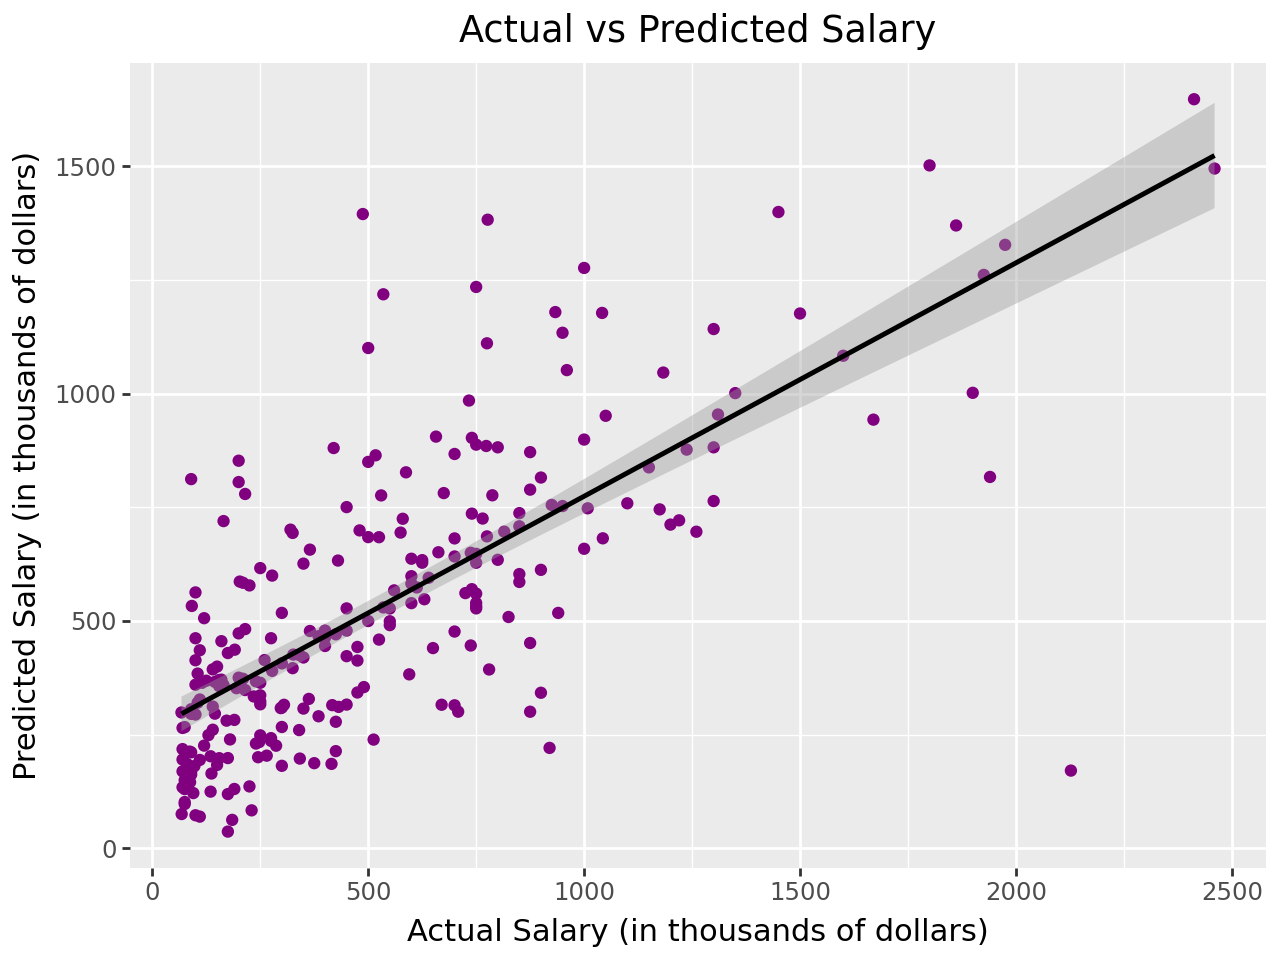

In [48]:
y_pred = final_fitted.predict(X)

plot_df = hitters[["Salary"]].copy()
plot_df["y_pred"] = y_pred

(ggplot(plot_df, aes(x = "Salary", y = "y_pred")) +
    geom_point(color = "purple") +
    geom_smooth(method = "lm") +
    labs(x = "Actual Salary (in thousands of dollars)", 
         y = "Predicted Salary (in thousands of dollars)", 
         title = "Actual vs Predicted Salary"))

The final model, using Elastic Net with $\lambda = 0.1$ and $\alpha = 0.8$, reported the lowest MSE across all model and regression combinations tested, which was somewhat surprising. While I expected Elastic Net to perform well due to its balanced combination of Lasso and Ridge penalties, I was more surprised that the best-performing model included every variable from the dataset. Initially, I thought a model with fewer, well-chosen features would reduce noise and improve focus on the most predictive variables. However, using all columns allowed the model to capture complex interactions and subtle influences across the full range of variables, creating a more comprehensive representation of the data.  

Elastic Net’s penalties helped to control multicollinearity and assigned zero or near-zero weights to less relevant features, effectively "selecting" the most important ones within the complete dataset. This regularization reduced the risk of overfitting, even with a large number of predictors. The plot of actual versus predicted salaries shows good accuracy, as most points lie near the diagonal line, indicating that predictions match well with actual values. There is some spread, especially for higher salary values, suggesting potential areas for further improvement, but the overall trend confirms the model’s strength in capturing the relationship between predictors and salary.

# Generative AI Statement  
I used ChatGPT-4o primarily to support the function-writing aspects of this lab, particularly in Part I. While I was already comfortable with writing pipelines and could refer to the GSB 544 textbook for much of the material, generative AI assisted in transforming processes into efficient functions and debugging issues. This support was especially useful for streamlining repetitive tasks, helping me avoid redundancy and refine my approach for greater efficiency.